In [1]:
# Core Python and scientific stack
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from glob import glob
from PIL import Image
from IPython.display import clear_output
clear_output(wait=True)

# Torch
import torch
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# torchvision utilities (e.g., transforms, datasets)
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset

## Importing Libraries

This cell loads all necessary libraries for the project:

- **Scientific stack**: `numpy`, `pandas`, `matplotlib`, `seaborn` for data handling and visualization.
- **File and image handling**: `glob`, `pathlib`, `PIL`, and `Image` for reading and displaying image files.
- **Jupyter utility**: `clear_output` is used to clean notebook output for better readability.
- **PyTorch**: libraries to build, train, and evaluate deep learning models.
- **Torchvision**: for image transformations and loading datasets organized by folders.

These libraries are essential to develop and train a convolutional neural network (CNN) for image classification tasks.


##  Device Selection

This cell defines the computing device to be used by PyTorch:

- If a GPU is available (`cuda`), it will be selected to accelerate training.
- Otherwise, the code will run on CPU.

Using a GPU significantly reduces training time for deep learning models.



In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 🧠 Dataset Loading

Here we define the path to the **Brain Tumor MRI Dataset** from Kaggle.

The dataset is divided into `Training` and `Testing` folders. The `os.listdir()` function is used to check that the path is correct and the data is properly loaded.

This dataset contains brain MRI images labeled to indicate whether the patient has a tumor or not.



In [8]:
# Classification-specific evaluation tools
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Importing dataset

data_dir = "/kaggle/input/brain-cancer-mri/brain_cancer_mri/Brain_Cancer_raw_MRI_data/Brain_Cancer"

print(os.listdir(data_dir))

['brain_tumor', 'brain_glioma', 'brain_menin']


##  Image Preprocessing

In this section, a set of transformations is defined to prepare the images for training:

- `Grayscale`: converts images to single-channel grayscale.
- `Resize`: resizes all images to 128x128 pixels for consistency.
- `ToTensor`: converts the images to PyTorch tensors.
- `Normalize`: scales pixel values to the range [-1, 1], which improves convergence during training.

These preprocessing steps are crucial to ensure all images are in the same format and scale.


In [33]:
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# Define transformation
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Load dataset from a single root folder
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Define split sizes
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size  # remaining

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # reproducibility
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print summary
print("Classes:", dataset.classes)
print(f"Total images: {total_size}")
print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")


Classes: ['brain_glioma', 'brain_menin', 'brain_tumor']
Total images: 6056
Train: 4239 | Val: 908 | Test: 909


## Custom CNN
The model used here is a simple convolutional neural network designed for multi-class classification on grayscale brain MRI images.

### Architecture:
1. **Conv2D Layer**
   - Input channels: 1 (grayscale images)
   - Output channels: 16
   - Kernel size: \(3 \times 3\)
   - Padding: 1 (preserves spatial size)
   - Activation: ReLU
   - MaxPooling: \(2 \times 2\) (reduces spatial resolution by half)
   - Output shape: \([B, 16, 64, 64]\)

2. **Conv2D Layer**
   - Input channels: 16
   - Output channels: 32
   - Kernel size: \(3 \times 3\)
   - Padding: 1
   - Activation: ReLU
   - MaxPooling: \(2 \times 2\)
   - Output shape: \([B, 32, 32, 32]\)

3. **Flatten Layer**
   - Flattens the output tensor into a vector of size \(32 \times 32 \times 32 = 32,768\)

4. **Fully Connected Layer (FC1)**
   - Input size: 32,768
   - Output size: 128
   - Activation: ReLU

5. **Fully Connected Layer (FC2)**
   - Input size: 128
   - Output size: 3 (number of classes)
   - Output: raw logits (used with `CrossEntropyLoss`)

## Custom CNN Architecture

This section defines the architecture of a custom convolutional neural network (CNN) using PyTorch. The model is designed for multi-class classification of grayscale brain MRI images.

- Two convolutional layers (`Conv2D`) extract spatial features from the images.
- Each convolutional layer is followed by a ReLU activation and max-pooling to reduce spatial dimensions.
- The output is flattened and passed through two fully connected layers to produce the final class scores.

The model is simple and lightweight, suitable for educational purposes and fast training.


In [34]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # changed from 3 to 1
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 3)  # 3 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 16, 64, 64]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 32, 32, 32]
        x = x.view(-1, 32 * 32 * 32)          # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


## Model Setup

- The model is moved to the appropriate device (CPU or GPU).
- `CrossEntropyLoss` is used as the loss function, appropriate for multi-class classification.
- The `Adam` optimizer is chosen for faster convergence, with a learning rate of 0.001 (which can be tuned).

These components are essential to train the network and minimize classification errors.


In [35]:
model = CustomCNN().to(device)
criterion = nn.CrossEntropyLoss()                    # Multiclass classification
optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam optimizer for faster convergence, LR can be tuned

## Training and Validation Loop

This loop trains the model for a defined number of epochs:

- **Training phase**:
  - The model is set to training mode.
  - For each batch, it computes the predictions, calculates the loss, performs backpropagation, and updates the weights.

- **Validation phase**:
  - The model is set to evaluation mode (no gradients).
  - Accuracy is computed over the validation set to monitor generalization.

Tracking both training loss and validation accuracy helps prevent overfitting and evaluate model performance after each epoch.


In [36]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # Validation phase
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}, Training loss: {avg_train_loss:.4f}, Validation accuracy: {val_accuracy:.2f}%")


Epoch 1, Training loss: 0.7569, Validation accuracy: 72.58%
Epoch 2, Training loss: 0.5942, Validation accuracy: 73.02%
Epoch 3, Training loss: 0.5334, Validation accuracy: 76.54%
Epoch 4, Training loss: 0.4763, Validation accuracy: 77.86%
Epoch 5, Training loss: 0.3827, Validation accuracy: 78.52%


## Test Evaluation and Confusion Matrix

After training, the model is evaluated on the test set:

- Accuracy is calculated as the percentage of correct predictions.
- A **confusion matrix** is generated to analyze how well the model performs for each class.

The confusion matrix provides a more detailed view of classification performance, highlighting possible class imbalances or confusion between similar categories.



Test accuracy: 81.96%


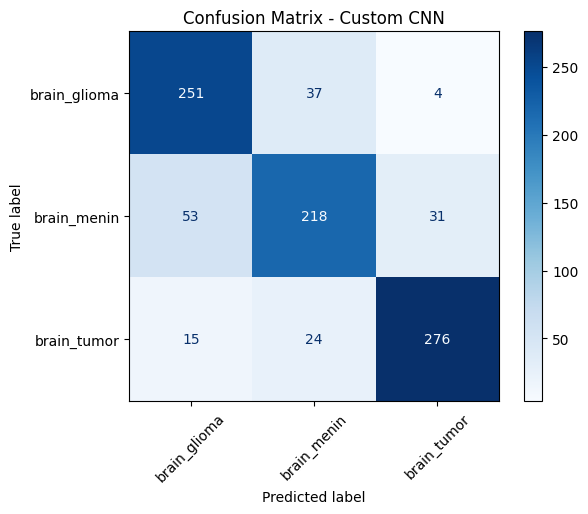

              precision    recall  f1-score   support

brain_glioma       0.79      0.86      0.82       292
 brain_menin       0.78      0.72      0.75       302
 brain_tumor       0.89      0.88      0.88       315

    accuracy                           0.82       909
   macro avg       0.82      0.82      0.82       909
weighted avg       0.82      0.82      0.82       909



In [37]:
# Evaluation of the model
model.eval()
test_correct = 0
test_total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * test_correct / test_total
print(f"\nTest accuracy: {test_accuracy:.2f}%")

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Custom CNN")
plt.show()

# Classification report
print(classification_report(all_labels, all_preds, target_names=dataset.classes))

### Confusion Matrix – Custom CNN

The confusion matrix above illustrates the performance of our **Custom CNN** in classifying brain MRI images into three categories: `brain_glioma`, `brain_menin`, and `brain_tumor`.

- The model achieved an overall **test accuracy of 81.96%**, indicating strong generalization on unseen data.
- Most predictions were correctly classified along the diagonal, particularly for the class **`brain_tumor`**, with **276 out of 315** samples classified correctly.
- The model also performed well on **`brain_glioma`**, correctly identifying **251 out of 292** samples.
- Some misclassifications occurred between **`brain_menin` and the other two classes**, suggesting that their features might be harder to distinguish with this model architecture.

This result demonstrates the effectiveness of our simple convolutional neural network, while also highlighting potential areas for improvement — such as refining class boundaries or applying data augmentation to reduce class confusion.


## Pretrained CNN
The `ResNet18` is one of the **smallest versions of ResNet**, with 18 layers. Is much faster to train and fine-tune, especially on small datasets. There is a lower risk of overfitting on small medical imaging datsets due to fewer parameters. Other ResNets might be bigger in terms of number of parameters and might be used for larger datasets or more complex tasks. 

⚡️ Rule of Thumb:
* Small dataset (few hundred to few thousand images): ResNet18 or ResNet34.
* Medium dataset (tens of thousands): ResNet34 or ResNet50.
* Large dataset (hundreds of thousands or more): ResNet50, ResNet101.

🟢 Alternatives to ResNet worth testing:
* EfficientNet-B0 (very compact, high performance per parameter).
* DenseNet121 (good at feature reuse, smaller footprint).
* MobileNetV2 (lightweight, good for deployment scenarios).

⚠️ **Issue with kaggle**: Kaggle environment is not able to access directly external URLs as it blocks outbound internet connections by default for security reasons, so it cannot download the pretrained weights directly from PyTorch servers. Here you would have two options:
1. Download the weights locally onyour machine from [here for ResNet18](https://download.pytorch.org/models/resnet18-f37072fd.pth) and upload the weights file to Kaggle via "Add Data" and load the model manually as:
 ```
 resnet = models.resnet18(weights=None)
 state_dict = torch.load("/kaggle/input/your-uploaded-folder/resnet18-f37072fd.pth", map_location=device)
 resnet.load_state_dict(state_dict)
 ```
2. Testing just the architecture of the network without using the pretrained weights:
 ```
resnet = models.resnet18(weights=None)
 ```

As this is just for teaching purposes and see how to use a pre-trained network, we will stick to Option 2. 

## Transfer Learning with a Pretrained CNN

This section introduces transfer learning using a pretrained ResNet18 architecture. ResNet18 is a compact and efficient convolutional neural network, well-suited for small datasets like medical images.

The idea behind transfer learning is to reuse a model trained on a large dataset (e.g., ImageNet) and adapt it to a new, smaller dataset by modifying and retraining only the final layers.

Due to Kaggle’s internet restrictions, pretrained weights must be uploaded manually rather than downloaded within the notebook.


## 🛠️ Modifying the Pretrained ResNet18

- The model is loaded without pretrained weights (`weights=None`) for demonstration.
- The first convolutional layer is modified to accept grayscale images (1 channel instead of 3).
- Optionally, all layers except the final fully connected layer are frozen (i.e., not trainable).
- The final fully connected layer is replaced to output predictions for 3 classes.

This setup allows us to use ResNet18’s feature extraction power while fine-tuning only the final classification layer.


In [38]:
import torch
import torch.nn as nn
from torchvision import models

# Load ResNet18 without pretrained weights
resnet = models.resnet18(weights=None)

# Modify the first convolutional layer to accept 1 input channel (grayscale images)
resnet.conv1 = nn.Conv2d(
    in_channels=1,         # Grayscale input
    out_channels=64,
    kernel_size=7,
    stride=2,
    padding=3,
    bias=False
)

# OPTIONAL: Freeze all layers except the final fully connected layer
for param in resnet.parameters():
    param.requires_grad = False

# Replace the final fully connected layer to output 3 classes
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 3)

# Move model to the right device (CPU or GPU)
resnet = resnet.to(device)


## Training and Validation (Pretrained ResNet18)

This block trains only the final layer of the pretrained ResNet18:

- **Training phase**: The model performs forward and backward passes for each batch in the training data.
- **Validation phase**: Accuracy is computed without gradient tracking.

Only the final classification layer is optimized to adapt to the new medical image dataset while keeping the rest of the network fixed.


In [39]:
import torch.optim as optim
import torch.nn as nn

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.fc.parameters(), lr=0.001)  # Only training the final layer

num_epochs = 5

for epoch in range(num_epochs):
    resnet.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # ----------------------
    # 🔍 Validation phase
    # ----------------------
    resnet.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}, Training loss: {avg_train_loss:.4f}, Validation accuracy: {val_accuracy:.2f}%")


Epoch 1, Training loss: 0.9784, Validation accuracy: 63.33%
Epoch 2, Training loss: 0.8861, Validation accuracy: 68.83%
Epoch 3, Training loss: 0.8548, Validation accuracy: 67.51%
Epoch 4, Training loss: 0.8154, Validation accuracy: 68.61%
Epoch 5, Training loss: 0.7895, Validation accuracy: 71.37%


## Testing the Pretrained ResNet18

The model is evaluated on the test set to measure its generalization performance:

- **Test accuracy** is calculated as the percentage of correctly predicted labels.
- A **confusion matrix** is plotted to visualize how predictions are distributed across classes.
- A **classification report** is printed, providing precision, recall, F1-score, and support for each class.

These metrics give insight into model performance, especially in the presence of class imbalance.


Test accuracy (ResNet18): 69.75%


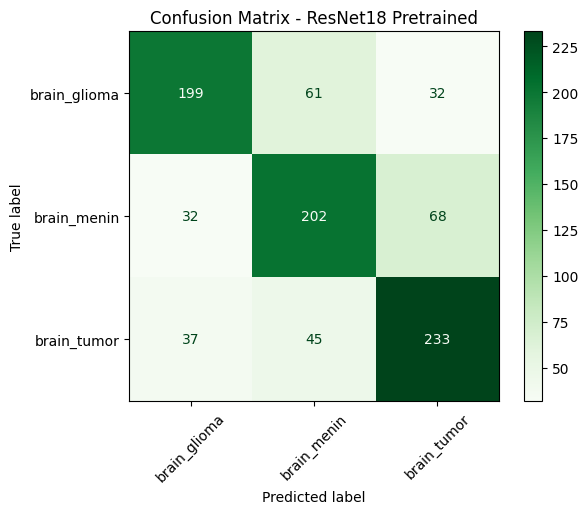

              precision    recall  f1-score   support

brain_glioma       0.74      0.68      0.71       292
 brain_menin       0.66      0.67      0.66       302
 brain_tumor       0.70      0.74      0.72       315

    accuracy                           0.70       909
   macro avg       0.70      0.70      0.70       909
weighted avg       0.70      0.70      0.70       909



In [40]:
# Evaluation
resnet.eval()
all_preds_resnet = []
all_labels_resnet = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds_resnet.extend(predicted.cpu().numpy())
        all_labels_resnet.extend(labels.cpu().numpy())

# Test accuracy
test_correct = sum(p == l for p, l in zip(all_preds_resnet, all_labels_resnet))
test_total = len(all_labels_resnet)
test_accuracy = 100 * test_correct / test_total
print(f'Test accuracy (ResNet18): {test_accuracy:.2f}%')

# Confusion matrix
cm_resnet = confusion_matrix(all_labels_resnet, all_preds_resnet)
disp_resnet = ConfusionMatrixDisplay(confusion_matrix=cm_resnet, display_labels=dataset.classes)
disp_resnet.plot(cmap='Greens', xticks_rotation=45)
plt.title("Confusion Matrix - ResNet18 Pretrained")
plt.show()

# Classification report
print(classification_report(all_labels_resnet, all_preds_resnet, target_names=dataset.classes))


### Confusion Matrix – ResNet18 Pretrained

The pretrained ResNet18 model achieved a **test accuracy of 69.75%** on the brain tumor classification task. The confusion matrix provides deeper insights into how the model performs across the three tumor types:

- **brain_glioma**: 199 correctly classified, but 61 misclassified as brain_menin and 32 as brain_tumor.
- **brain_menin**: 202 correctly predicted, with 32 misclassified as brain_glioma and 68 as brain_tumor.
- **brain_tumor**: 233 correct predictions, but with 37 confused as brain_glioma and 45 as brain_menin.

🔍 **Observations**:
- The model struggles the most with distinguishing between **brain_menin** and the other two classes, particularly **brain_tumor**, as shown by the relatively high number of misclassifications (68).
- The performance is less robust compared to the custom CNN, indicating that although ResNet18 provides a strong starting point, further fine-tuning or architectural adaptation may be necessary for this specific medical dataset.

This highlights the importance of domain-specific tuning when using pretrained models on medical imaging tasks.



# Object Detetion
In this section, we will use **YOLOv8 (You Only Look Once)** for object detection on medical images (brain tumor detection).  
YOLO is one of the most popular and efficient architectures for object detection tasks because of its speed and ease of use.

### ⚠️ Dataset Preparation (The Real Challenge!)

One of the **most complex and critical steps** when using YOLO (any version, including YOLOv8) is not the model itself, but the **preparation of the dataset and the correct formatting of the labels**.

YOLO requires:
- **Images folder**: containing your `.jpg` or `.png` files.
- **Labels folder**: with `.txt` files for each image, containing annotations in the format:
  ```
  class x_center y_center width height
  ```
  where all coordinates are **normalized between 0 and 1** relative to the image dimensions.

The dataset structure typically looks like this:
```
dataset/
├── train/
│   ├── images/
│   └── labels/
├── valid/
│   ├── images/
│   └── labels/
├── data.yaml
```

The `data.yaml` configuration file tells YOLO where to find the training and validation sets and defines the class names.

Example `data.yaml`:
```yaml
train: /path/to/train/images
val: /path/to/valid/images
names:
  0: tumor
```

Carefully preparing this format is **essential** for proper training and evaluation.  
Incorrect label formatting or path definitions are common sources of errors when working with YOLO-based models.

---

In this notebook, we will work directly with a **pre-prepared dataset** in YOLO format to focus on training, inference, and evaluation.

## Object Detection with YOLOv8

This section introduces object detection using **YOLOv8 (You Only Look Once)**, a fast and efficient architecture ideal for real-time detection tasks.

We apply YOLOv8 to medical images (specifically brain MRI scans) to detect the presence and location of tumors. The focus is on understanding how the dataset must be structured and how to configure the model for training and inference.


## Setting Up YOLOv8

- We install the `ultralytics` package, which provides the latest YOLOv8 implementation.
- We load the **YOLOv8n** variant (`n` = nano) for faster training and lower resource usage.

This setup allows us to train and test object detection models directly within the notebook.


In [41]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.5/983.5 kB 20.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found exi

In [42]:
# YOLO object detection library
from ultralytics import YOLO

# Load YOLOv8 nano (fastest variant)
model = YOLO('yolov8n.pt')  # 'n' = nano, prioritize speed

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 86.8MB/s]


## Dataset Preparation for YOLOv8

Correct dataset formatting is **crucial** when working with YOLO models. YOLO expects:

- A folder with `.jpg` or `.png` images.
- A corresponding `labels/` folder with `.txt` files, one per image, containing bounding box annotations.

Annotations must follow this format

## Customizing Dataset Configuration

We update the default `data.yaml` to set the **absolute paths** to our training and validation image directories.

This is necessary because the Kaggle environment requires full paths to access files correctly. The updated file is saved to `/kaggle/working/data.yaml` for use during training.




In [43]:
import yaml

# Define input YAML path (from your Kaggle dataset)
input_yaml_path = '/kaggle/input/brain-tumor-yolo/brain_tumor_yolo/data.yaml'


# Define correct absolute paths to your train and val images folders
train_images_path = '/kaggle/input/brain-tumor-yolo/brain_tumor_yolo/train/images'
val_images_path = '/kaggle/input/brain-tumor-yolo/brain_tumor_yolo/valid/images'

# Load the original YAML
with open(input_yaml_path, 'r') as file:
    data_yaml = yaml.safe_load(file)

# Modify the paths
data_yaml['train'] = train_images_path
data_yaml['val'] = val_images_path

# Write the updated YAML to /kaggle/working/
output_yaml_path = '/kaggle/working/data.yaml'
with open(output_yaml_path, 'w') as file:
    yaml.dump(data_yaml, file)

print(f"✅ YAML updated and saved to: {output_yaml_path}")
print("YAML content:")
print(data_yaml)


✅ YAML updated and saved to: /kaggle/working/data.yaml
YAML content:
{'train': '/kaggle/input/brain-tumor-yolo/brain_tumor_yolo/train/images', 'val': '/kaggle/input/brain-tumor-yolo/brain_tumor_yolo/valid/images', 'nc': 2, 'names': ['negative', 'positive']}


## 🚀 Training the YOLOv8 Model

The YOLOv8 model is trained using:

- `input_yaml_path`: location of the dataset configuration file.
- Custom settings: 2 epochs, image size 416x416, batch size of 8, and confidence threshold of 0.3.

Training for more epochs and adjusting hyperparameters can improve performance. For demonstration purposes, a short training is used here.


In [45]:
model.train(
    data=output_yaml_path,  # Use the updated YAML with correct Kaggle paths
    epochs=2,
    imgsz=416,
    batch=8,
    conf=0.3,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    verbose=False
)


Ultralytics 8.3.115 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/data.yaml, epochs=2, time=None, patience=100, batch=8, imgsz=416, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=0.3, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, 

100%|██████████| 755k/755k [00:00<00:00, 23.6MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /kaggle/input/brain-tumor-yolo/brain_tumor_yolo/train/labels... 878 images, 15 backgrounds, 0 corrupt: 100%|██████████| 893/893 [00:03<00:00, 231.13it/s]

WARNING ⚠️ train: Cache directory /kaggle/input/brain-tumor-yolo/brain_tumor_yolo/train is not writeable, cache not saved.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 0.7±0.3 MB/s, size: 3.4 KB)


val: Scanning /kaggle/input/brain-tumor-yolo/brain_tumor_yolo/valid/labels... 223 images, 0 backgrounds, 0 corrupt: 100%|██████████| 223/223 [00:00<00:00, 227.91it/s]


WARNING ⚠️ val: Cache directory /kaggle/input/brain-tumor-yolo/brain_tumor_yolo/valid is not writeable, cache not saved.
Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 0 dataloader workers
Logging results to runs/detect/train2
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2         0G      1.414      2.839      1.139          7        416: 100%|██████████| 112/112 [03:24<00:00,  1.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:20<00:00,  1.48s/it]

                   all        223        241          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2         0G      1.207      1.929      1.059          5        416: 100%|██████████| 112/112 [03:16<00:00,  1.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:28<00:00,  2.02s/it]

                   all        223        241      0.477      0.583      0.399      0.297



2 epochs completed in 0.125 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.115 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:18<00:00,  1.35s/it]


                   all        223        241      0.476      0.583      0.398      0.297


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 1.7ms preprocess, 72.8ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79475442a190>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

## Inference on Validation Images

Once trained, we load the best-performing YOLOv8 weights and use the model to make predictions on the validation set.

- Inference is done **without saving** the output images to disk.
- We define the confidence and IoU thresholds for filtering predictions.

This step allows us to visualize and assess the model’s detection performance.


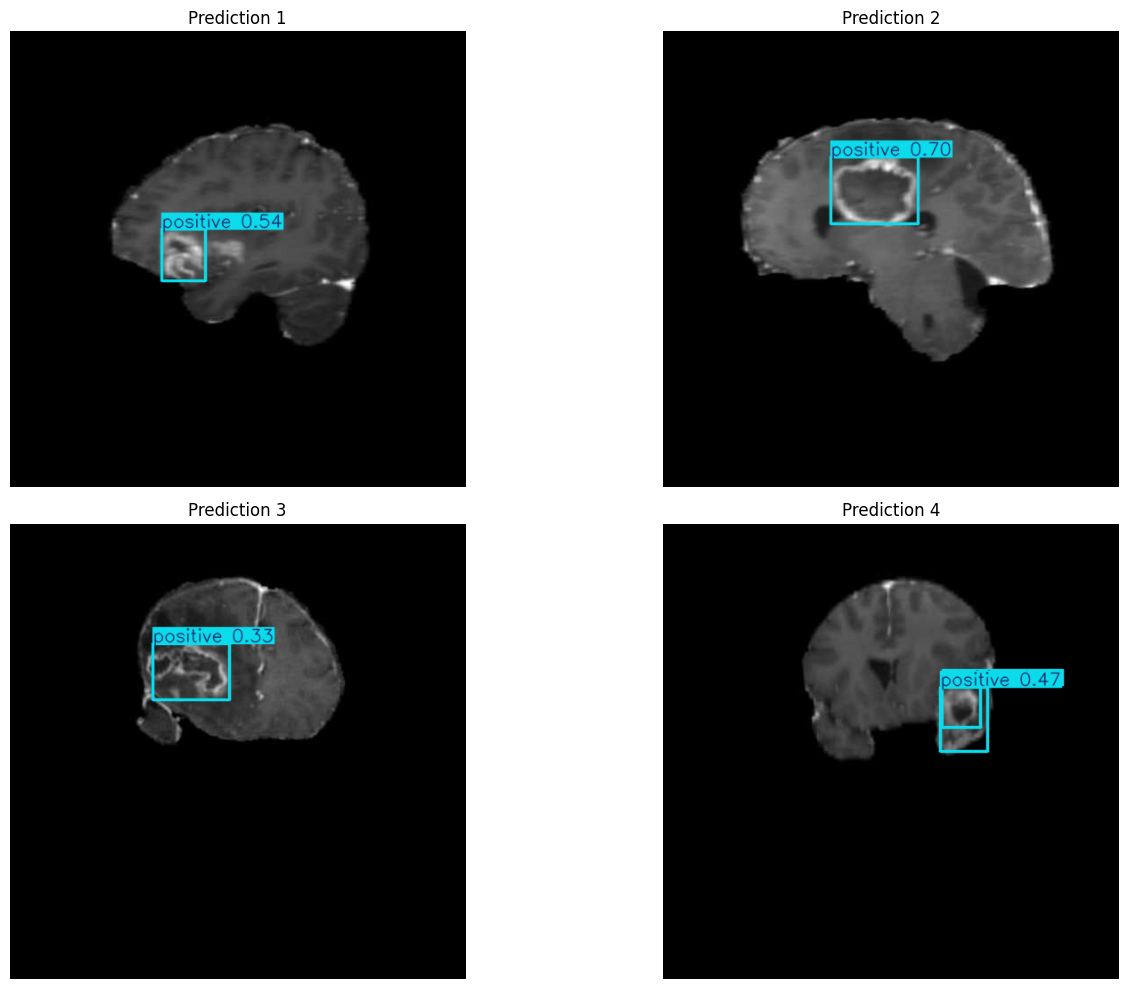

In [46]:
# Load the trained model
model_path = 'runs/detect/train2/weights/best.pt'  # Adjust path if different
model = YOLO(model_path)

# Define the directory with validation images
source_dir = '/kaggle/input/brain-tumor-yolo/brain_tumor_yolo/valid/images'


# Run inference WITHOUT saving the images
results = model.predict(
    source=source_dir,
    save=False,               # Don't save to disk
    conf=0.3,                 # Confidence threshold
    iou=0.5,                  # IoU threshold
    device='cuda' if torch.cuda.is_available() else 'cpu',
    imgsz=416,
    verbose=False
)

# Show the first few predictions inline
plt.figure(figsize=(15, 10))
for i, result in enumerate(results[:4]):   # Show first 4 images
    img = Image.fromarray(result.plot()[..., ::-1])  # result.plot() returns BGR numpy array
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(f"Prediction {i+1}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Segmentation

Dataset from the Cell Tracking Challenge, focused on cell segmentation. This dataset contains **phase contrast microscopy images** of _stem cells_ growing. 

You can add this dataset to your notebook by clicking "Add Input" on the left side of the screen, and selecting **PhC-C2DL-PSC - Cell Tracking Challenge**.

Each sample includes:

* **Input image**: a grayscale microscopy image of cells.
* **Segmentation mask**

For researching purposes we will train a custom UNet build block by block and a UNet architecture from MONAI. 


- **Install MONAI**: MONAI is a library for medical image processing and pre-trained neural networks. We use a MONAI **UNet model** for image segmentation.

- **Data Preparation**:
  - Load images and segmentation masks from the corresponding folders.
  - Filter matching image and mask paths to ensure each image has its associated mask.

- **Dataset and DataLoader**:
  - Create a DataLoader to load images and masks in batches.
  - Check the dimensions of a batch of images and masks to ensure they are loaded correctly.


In [2]:
!pip install -q monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 16.5 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 5.6 MB/s eta 0:00:000:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but you have pylibraft-cu12 25.2.0 whic

In [3]:

from monai.transforms import Compose, Resize, ToTensor
from monai.networks.nets import UNet

# Evaluation (later)
from sklearn.metrics import jaccard_score

2025-04-23 21:49:40.255789: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745444980.517940      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745444980.587258      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
image_dir = '/kaggle/input/segmentation-agora/PhC-C2DL-PSC/PhC-C2DL-PSC/01'
mask_dir = '/kaggle/input/segmentation-agora/PhC-C2DL-PSC/PhC-C2DL-PSC/01_ST/SEG'


image_paths = sorted(glob(os.path.join(image_dir, '*.tif')))
mask_paths  = sorted(glob(os.path.join(mask_dir, '*.tif')))

# Build a lookup of image name endings → full path
image_dict = {os.path.splitext(os.path.basename(p))[0][-3:]: p for p in image_paths}
mask_dict  = {os.path.splitext(os.path.basename(p))[0][-3:]: p for p in mask_paths}

# Intersect keys to find matching image/mask pairs
matching_keys = sorted(set(image_dict.keys()) & set(mask_dict.keys()))

filtered_image_paths = [image_dict[k] for k in matching_keys]
filtered_mask_paths  = [mask_dict[k] for k in matching_keys]

print(f"✅ Found {len(filtered_image_paths)} image-mask pairs.")

✅ Found 300 image-mask pairs.


In [5]:
class CellSegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, image_size=(128, 128)):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),                  # Converts to [0, 1] float tensor
            transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize grayscale images
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image and mask
        image = Image.open(self.image_paths[idx]).convert('L')  # Force grayscale ('L')
        mask = Image.open(self.mask_paths[idx]).convert('L')

        # Apply transforms
        image = self.transform(image)
        mask = self.transform(mask)
        mask = (mask > 0).float()  # Convert mask to binary (0 or 1)

        return image, mask

In [6]:
# Assuming image_paths and mask_paths are already defined and sorted correctly
dataset = CellSegmentationDataset(image_paths, mask_paths)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Check one batch
images, masks = next(iter(dataloader))
print(images.shape)  # Should be [B, 1, H, W]
print(masks.shape)   # Should be [B, 1, H, W]

torch.Size([4, 1, 128, 128])
torch.Size([4, 1, 128, 128])


## Custom UNet

In [15]:
class SimpleUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(SimpleUNet, self).__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.up1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.out_conv = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        b = self.bottleneck(self.pool2(e2))
        d2 = self.dec2(torch.cat([self.up2(b), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return torch.sigmoid(self.out_conv(d1))


This is a simplified version of the U-Net architecture, primarily used for image segmentation tasks. It takes grayscale input images and outputs a pixel-wise segmentation mask.

### Architecture Overview:

#### Encoder:
- **Block 1**:  
  - `Conv2D`: (1 → 32 channels), Kernel: (3×3), ReLU  
  - `Conv2D`: (32 → 32 channels), Kernel: (3×3), ReLU  
  - `MaxPool2D`: (2×2)

- **Block 2**:  
  - `Conv2D`: (32 → 64 channels), Kernel: (3×3), ReLU  
  - `Conv2D`: (64 → 64 channels), Kernel: (3×3), ReLU  
  - `MaxPool2D`: (2×2)

#### Bottleneck:
- **Block 3**:  
  - `Conv2D`: (64 → 128 channels), Kernel: (3×3), ReLU  
  - `Conv2D`: (128 → 128 channels), Kernel: (3×3), ReLU

#### Decoder:
- **Block 2**:  
  - `ConvTranspose2D`: (128 → 64 channels), Kernel: (2×2), Stride: 2  
  - `Conv2D`: (128 → 64 channels), Kernel: (3×3), ReLU  
  - `Conv2D`: (64 → 64 channels), Kernel: (3×3), ReLU

- **Block 1**:  
  - `ConvTranspose2D`: (64 → 32 channels), Kernel: (2×2), Stride: 2  
  - `Conv2D`: (64 → 32 channels), Kernel: (3×3), ReLU  
  - `Conv2D`: (32 → 32 channels), Kernel: (3×3), ReLU

#### Output:
- `Conv2D`: (32 → 1 channel), Kernel: (1×1)  
- `Sigmoid` activation: Produces output in [0, 1] for binary segmentation



This **Simple U-Net** follows an encoder-decoder structure with skip connections. U-Net is a convolutional neural network architecture specifically designed for image segmentation tasks. It uses convolutional layers not only to extract spatial features in the encoder by progressively downsampling the input, but also to reconstruct fine details in the decoder by upsampling the features to produce a segmentation mask. Skip connections help preserve spatial information by directly linking encoder and decoder layers at the same resolution level.



In [16]:
model = SimpleUNet(in_channels=1, out_channels=1).to(device)

# Loss function: Binary Cross Entropy (BCE)
criterion = nn.BCELoss()  # You can replace with DiceLoss or BCE+Dice if you want

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5  # Adjust if needed

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        preds = model(images)
        loss = criterion(preds, masks)

        # Backward pass and optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Avg Training Loss: {avg_loss:.4f}")

Epoch [1/5] - Avg Training Loss: 0.2480
Epoch [2/5] - Avg Training Loss: 0.1045
Epoch [3/5] - Avg Training Loss: 0.0657
Epoch [4/5] - Avg Training Loss: 0.0527
Epoch [5/5] - Avg Training Loss: 0.0467


### Model Training

This section trains the Simple U-Net model for a binary segmentation task.

- **Model Initialization**:  
  The `SimpleUNet` is instantiated with 1 input and 1 output channel, suitable for grayscale images and binary masks.

- **Loss Function**:  
  `BCELoss` (Binary Cross Entropy) is used to measure the error between predicted and ground truth masks.  
  > Optionally, you can replace it with `DiceLoss` or a combination of `BCE + Dice` for better performance on imbalanced datasets.

- **Optimizer**:  
  `Adam` optimizer is used with a learning rate of `0.001`.

- **Training Loop**:
  - For each epoch:
    - Set model to training mode.
    - Loop over the batches of images and masks:
      - Perform forward pass to obtain predictions.
      - Compute loss.
      - Backpropagate and update weights.
    - Print the average training loss for the epoch.

- The model was trained for **5 epochs**.

The training loss decreased consistently over time, indicating that the model was learning and improving its predictions. This steady drop in loss suggests that the model is converging well and learning to produce accurate segmentation masks.

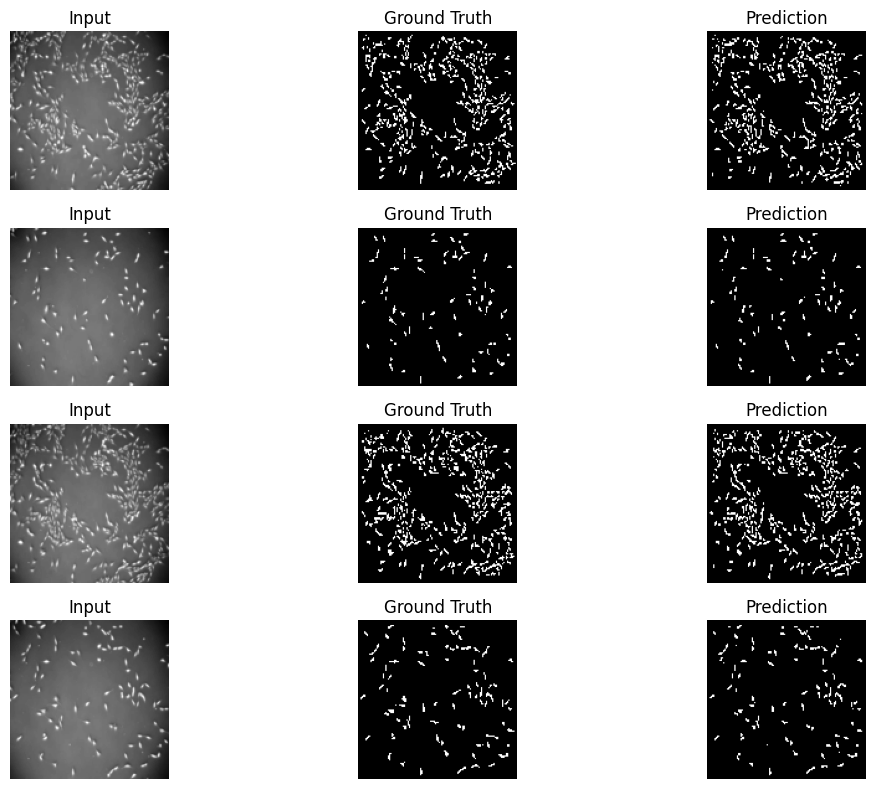

In [20]:
model.eval()
with torch.no_grad():
    images, masks = next(iter(dataloader))  # Get one batch
    images = images.to(device)
    preds = model(images).cpu()
    preds = (preds > 0.5).float()  # Binarize predictions

# Show first 4 samples
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for i in range(4):
    plt.subplot(4, 3, i * 3 + 1)
    plt.imshow(images[i].cpu().squeeze(), cmap='gray')
    plt.title("Input")
    plt.axis('off')

    plt.subplot(4, 3, i * 3 + 2)
    plt.imshow(masks[i].cpu().squeeze(), cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(4, 3, i * 3 + 3)
    plt.imshow(preds[i].squeeze(), cmap='gray')
    plt.title("Prediction")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [21]:
def dice_score(pred, target, epsilon=1e-6):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return (2. * intersection + epsilon) / (pred.sum() + target.sum() + epsilon)

# Example for the first sample
dice = dice_score(preds[0], masks[0])
print(f"Dice score (sample 0): {dice:.4f}")

Dice score (sample 0): 0.8503


### Model Evaluation

- **Evaluation Mode**: The model is set to `.eval()` and gradients are disabled using `torch.no_grad()` for inference.
- **Batch Prediction**: A batch of input images is passed through the model to generate segmentation masks.
- **Binarization**: Predictions are thresholded at 0.5 to obtain binary masks.
- **Metric – Dice Score**:
  - Measures overlap between prediction and ground truth.
  - Values range from 0 (no overlap) to 1 (perfect match).
  - Score for one sample: **0.8503**, indicating high segmentation accuracy.


## MONAI UNet

The MONAI `UNet` is **highly modular and configurable**, offering powerful features for building flexible segmentation networks.

### Key Features:

- **Arbitrary number of layers**: Configure depth by adjusting the `channels` and `strides` sequences.

- **Customizable architecture**  
  - `channels` (feature map sizes at each level)
  - `strides` (downsampling/upsampling factor)
  - `kernel_size` and `up_kernel_size`

- **Residual Units Support**: Optional use of residual blocks via `num_res_units`.

- **Normalization and Dropout**  
  Built-in support for:
  - Normalization (`InstanceNorm`, `BatchNorm`, etc.)
  - Dropout layers

- **Flexible Activation Functions**: Choose from a variety of activations, e.g., `PReLU`, `ReLU`, `LeakyReLU`.

- **Advanced Layer Blocks**: Uses `Convolution` and `ResidualUnit` blocks with parameterized control.

- **Skip Connections & Transpose Convolutions**: Built-in skip logic using `SkipConnection` modules and transposed convolutions, with residual support in the decoding path.


In [9]:
# MONAI UNet setup
model_monai = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,  # Binary segmentation
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

# Loss and optimizer (same as SimpleUNet for fair comparison)
criterion_monai = nn.BCEWithLogitsLoss()
optimizer_monai = optim.Adam(model_monai.parameters(), lr=0.001)

### Image Segmentation with MONAI's UNet

In this section, we will use a predefined **UNet** model from the [**MONAI**](https://monai.io/) framework, which is specifically designed for deep learning in medical imaging. MONAI provides a robust and optimized implementation of UNet that is ready to use for segmentation tasks. 


Here's a breakdown of the setup:
- **Input and Output**:
  - Input: 1-channel (grayscale) images.
  - Output: 1-channel binary mask (segmentation output).

- **Architecture Details**:
  - Classic encoder-decoder UNet structure.
  - Channels per layer: `(16, 32, 64, 128, 256)`.
  - Strides: `(2, 2, 2, 2)` for downsampling.
  - `num_res_units=2`: Each level has two residual units, improving learning capacity.

- **Loss Function**:
  - `BCEWithLogitsLoss`: Combines a sigmoid layer and binary cross-entropy in a single, stable function.
  - Suitable for binary segmentation tasks.

- **Optimizer**:
  - `Adam` with learning rate `0.001`.
  - Chosen for its adaptive behavior and fast convergence.

- **Why MONAI?**
  - MONAI provides robust, tested, and optimized models for medical imaging.
  - Saves time and ensures best practices for network design.

> 💡 Keeping the loss and optimizer identical to the SimpleUNet ensures a **fair comparison** between models.



In [15]:
# Training
num_epochs = 5  # Adjust as needed

for epoch in range(num_epochs):
    model_monai.train()
    running_loss = 0.0

    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)

        preds = model_monai(images)
        loss = criterion_monai(preds, masks)

        optimizer_monai.zero_grad()
        loss.backward()
        optimizer_monai.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)
    print(f"MONAI UNet - Epoch [{epoch+1}/{num_epochs}] - Avg Training Loss: {avg_loss:.4f}")

MONAI UNet - Epoch [1/5] - Avg Training Loss: 0.3157
MONAI UNet - Epoch [2/5] - Avg Training Loss: 0.2780
MONAI UNet - Epoch [3/5] - Avg Training Loss: 0.2425
MONAI UNet - Epoch [4/5] - Avg Training Loss: 0.2099
MONAI UNet - Epoch [5/5] - Avg Training Loss: 0.1811


### Training Loop: Same Structure, Different Models

We use the **same training loop** structure for both the simple UNet and the MONAI UNet to ensure a **fair comparison**. Only the components related to each model are different.

- 🔁 **Loop logic**:
  - Identical for both models: forward pass → loss → backward pass → optimizer step → loss logging.

- ⚙️ **What changes**:
  - `model` → `model_monai`
  - `criterion` → `criterion_monai`
  - `optimizer` → `optimizer_monai`

- **Why?**
  - Keeping the training pipeline consistent helps isolate the **performance differences** to the model architecture itself.


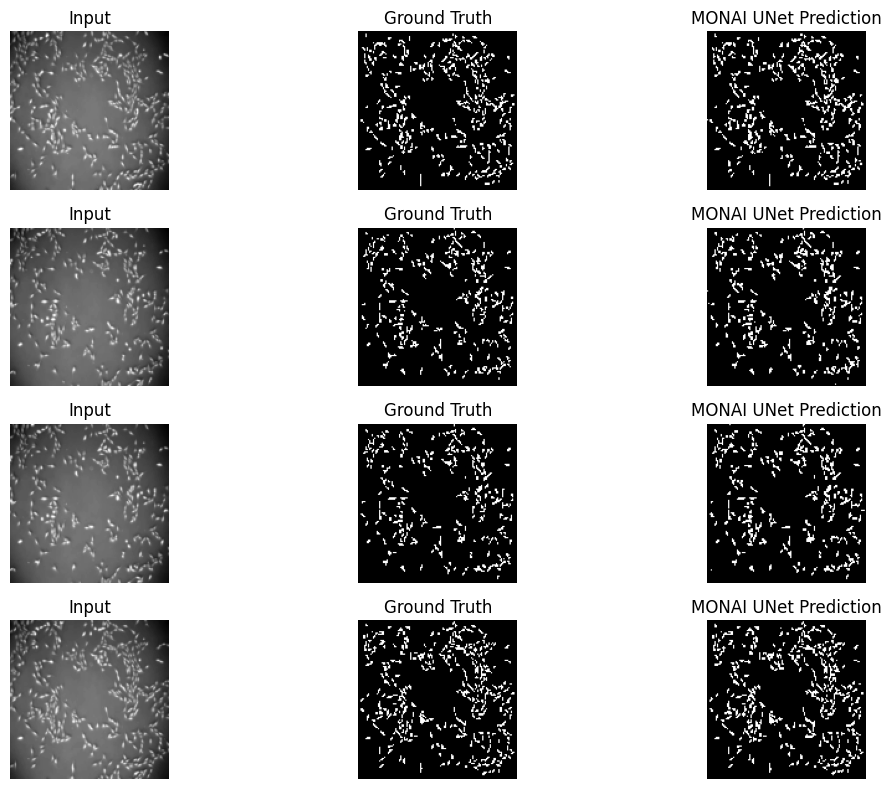

Dice score (sample 0) - MONAI UNet: 0.9285


In [16]:
# Evaluation
model_monai.eval()
with torch.no_grad():
    images, masks = next(iter(dataloader))
    images = images.to(device)
    preds = torch.sigmoid(model_monai(images)).cpu()  # 👈 Sigmoid here!
    preds = (preds > 0.5).float()                     # Binarize predictions

# Plot predictions
plt.figure(figsize=(12, 8))
for i in range(4):
    plt.subplot(4, 3, i * 3 + 1)
    plt.imshow(images[i].cpu().squeeze(), cmap='gray')
    plt.title("Input")
    plt.axis('off')

    plt.subplot(4, 3, i * 3 + 2)
    plt.imshow(masks[i].cpu().squeeze(), cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(4, 3, i * 3 + 3)
    plt.imshow(preds[i].squeeze(), cmap='gray')
    plt.title("MONAI UNet Prediction")
    plt.axis('off')

plt.tight_layout()
plt.show()

dice = dice_score(preds[0], masks[0])
print(f"Dice score (sample 0) - MONAI UNet: {dice:.4f}")

### Model Evaluation

We apply the **same evaluation procedure** as before to ensure a consistent comparison, with only slight changes adapted to MONAI's UNet output.

- **What's different from the previous model**:
  - Output of the model is passed through `torch.sigmoid()` since `BCEWithLogitsLoss` expects raw logits during training.
  - We apply an **explicit sigmoid** activation at evaluation time for MONAI's UNet, since logits are used directly during training.

- **Dice Score (as before)**:
  - Same metric, same calculation — different model.
  - Score for one sample: 0.9285 - high accuracy. 
